In [17]:
# Standard DS imports
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.svm import SVC
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import time

# All pytorch dependencies
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch

# all tensorflow dependencies
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras

In [18]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [25]:
# Global var for selecting popularity cutoff
MINIMUM_POPULARITY_LIMIT = 70
MINIMUM_POPULARITY_PERCENTAGE = MINIMUM_POPULARITY_LIMIT / 100

In [26]:
# Initialize the DataFrame
if 'results_df' not in globals():
    results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])


def analyze_algorithm(y_true, y_pred, algorithm):
    global results_df

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(accuracy, 6)}")

    precision = precision_score(y_true, y_pred, average='macro')
    print(f"Precision: {round(precision, 6)}")

    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Recall: {round(recall, 6)}")

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {round(f1, 6)}")

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    print(f"AUPRC: {round(auprc, 6)}")

    # Create a temporary DataFrame for the new row
    new_row_df = pd.DataFrame({
        'algorithm': [algorithm],
        'accuracy': [round(accuracy, 6)],
        'precision': [round(precision, 6)],
        'recall': [round(recall, 6)],
        'f1_score': [round(f1, 6)],
        'AUPRC': [round(auprc, 6)]
    })

    # Use pd.concat() to append the new row
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)

    # Visualize the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True, )

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()


def predict_and_convert(model, x_data, y_data, cutoff):
    y_scores = model.predict(x_data)
    y_pred = (y_scores > cutoff).astype(int)
    y_data = (y_data > cutoff).astype(int)
    return y_data, y_pred


def find_best_kernel_value(is_classifier, x_train, y_train, x_test, y_test):
    k_values = range(1, 100, 4)
    train_scores = []
    test_scores = []
    scores_dict = {}

    for k in tqdm(k_values):
        model = neighbors.KNeighborsClassifier(k) if is_classifier else neighbors.KNeighborsRegressor(k)
        model.fit(x_train, y_train.values.ravel())

        y_train_predicted = model.predict(x_train)
        y_test_predicted = model.predict(x_test)

        if is_classifier:
            train_scores.append(f1_score(y_train, y_train_predicted, average='macro'))
            test_score = f1_score(y_test, y_test_predicted, average='macro')
        else:
            y_train_binary = (y_train >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_train_predicted_binary = (y_train_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_binary = (y_test >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_predicted_binary = (y_test_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)

            # Then, compute the accuracy
            train_scores.append(f1_score(y_train_binary, y_train_predicted_binary, average='macro'))
            test_score = f1_score(y_test_binary, y_test_predicted_binary, average='macro')

        test_scores.append(test_score)
        scores_dict[k] = test_score

    plt.plot(k_values, train_scores, 'r-s', label='Train')
    plt.plot(k_values, test_scores, 'b-o', label='Test')
    plt.legend()
    plt.show()

    best_k = max(scores_dict, key=scores_dict.get)
    print(f"The best k value is : {best_k} with score: {scores_dict[best_k]}")

    return best_k


@keras.saving.register_keras_serializable()
def f1_score_nn(y_true, y_pred):
    # Calculate Precision and Recall
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_pred, 0, 1)) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_true, 0, 1)) + K.epsilon())

    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

tracks.csv read in successfully as a dataframe


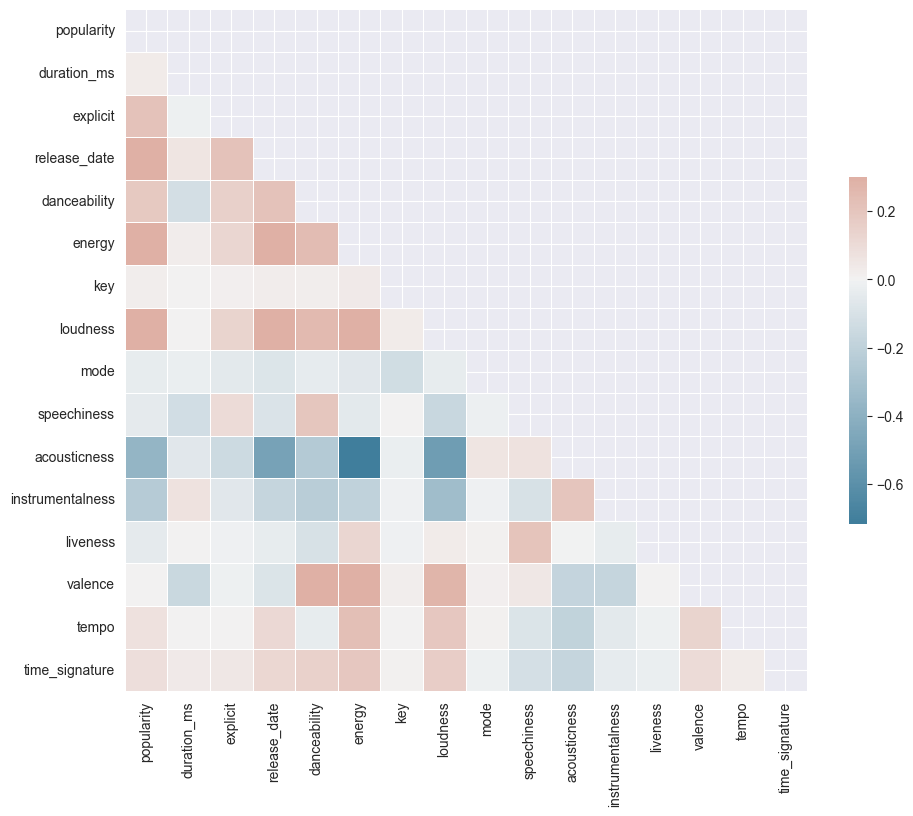

100%|██████████| 25/25 [13:15<00:00, 31.81s/it]


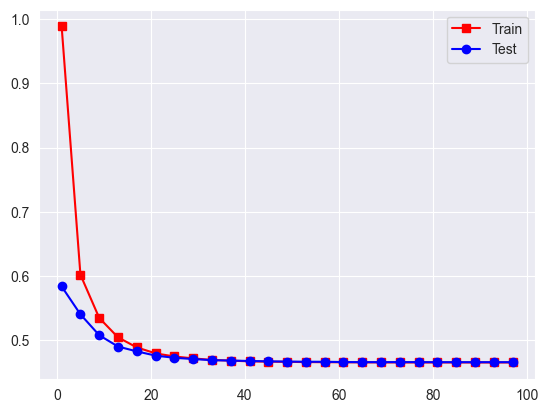

The best k value is : 1 with score: 0.5837507062206023
KNN-Regressor Training...
KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.994931
Precision: 0.987774
Recall: 0.988039
F1 Score: 0.987906
AUPRC: 0.979938


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_41125/236810242.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row_df], ignore_index=True)


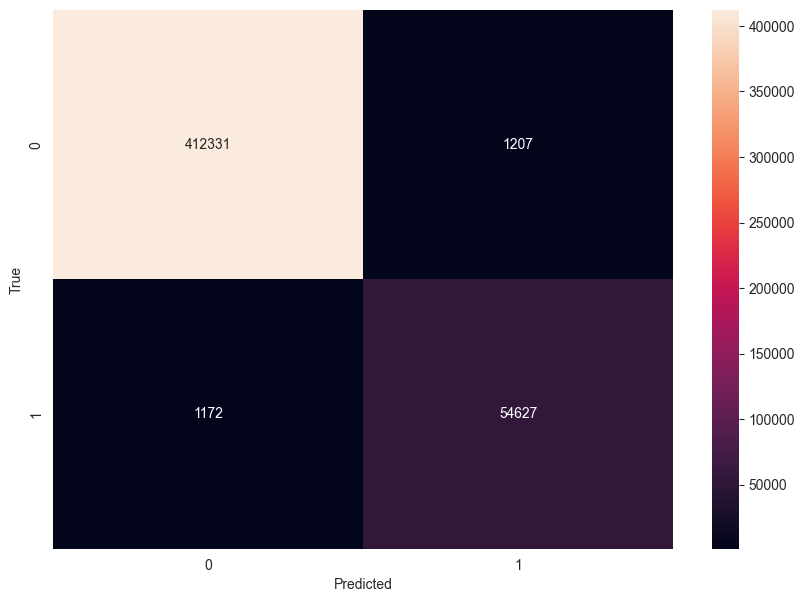


scores for the testing set:
Accuracy: 0.822099
Precision: 0.579525
Recall: 0.583199
F1 Score: 0.581265
AUPRC: 0.306779


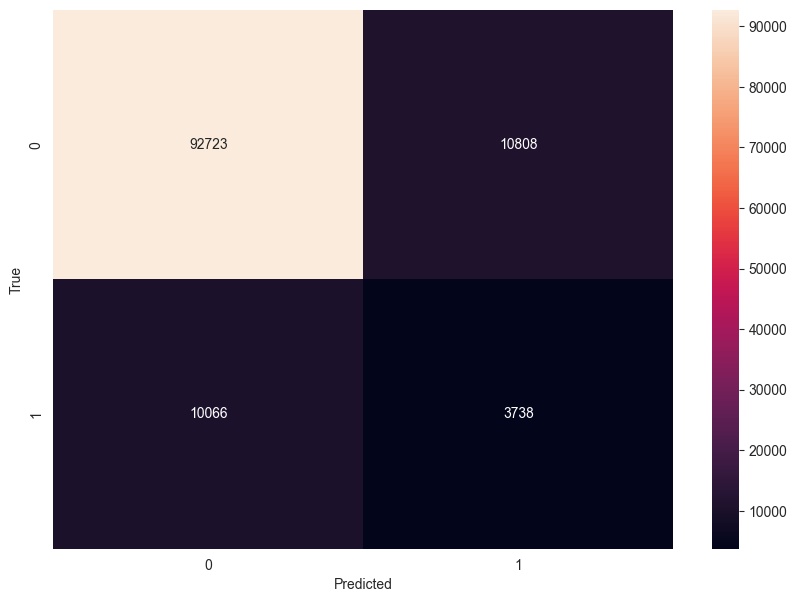

100%|██████████| 25/25 [14:47<00:00, 35.51s/it]


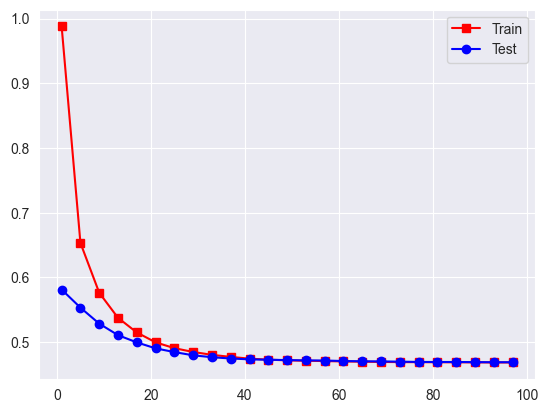

The best k value is : 1 with score: 0.5812653842287421
KNN-Classifier Training...
KNN-Classifier Fitted

scores for the training set:
Accuracy: 0.994931
Precision: 0.987774
Recall: 0.988039
F1 Score: 0.987906
AUPRC: 0.979938


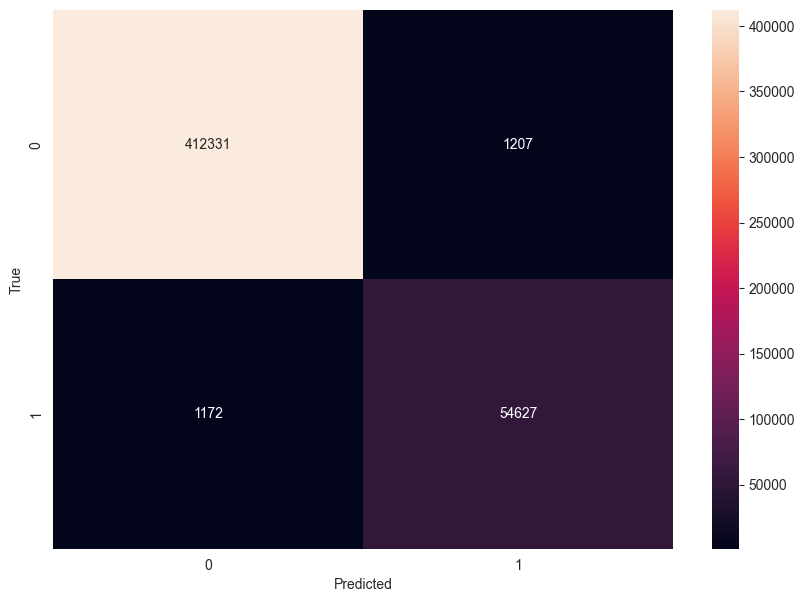


scores for the testing set:
Accuracy: 0.822099
Precision: 0.579525
Recall: 0.583199
F1 Score: 0.581265
AUPRC: 0.306779


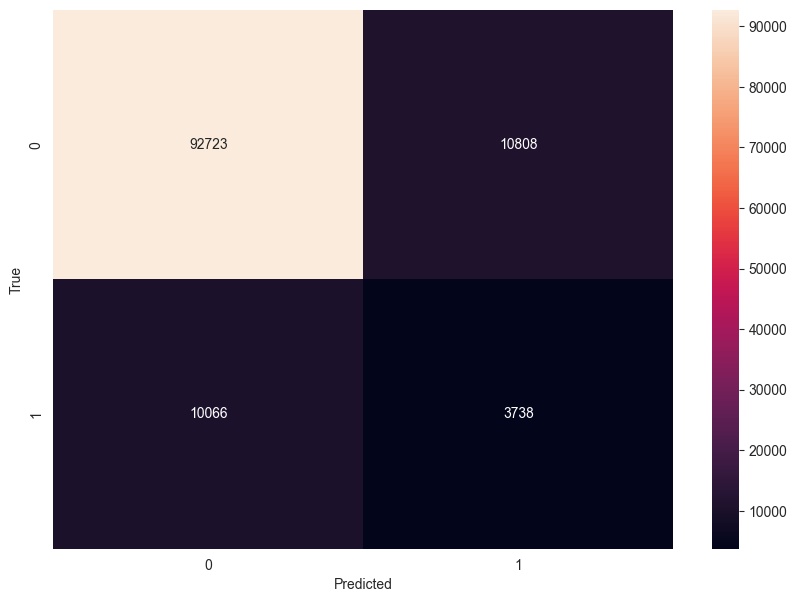

Epoch 1/50
4623/4694 [============================>.] - ETA: 0s - loss: 1.2242 - f1_score_nn: 0.3201
Epoch 1: val_f1_score_nn improved from -inf to 0.35777, saving model to best_model.keras
4694/4694 [==============================] - 4s 754us/step - loss: 1.2232 - f1_score_nn: 0.3204 - val_loss: 0.4873 - val_f1_score_nn: 0.3578
Epoch 2/50
4631/4694 [============================>.] - ETA: 0s - loss: 1.1698 - f1_score_nn: 0.3387
Epoch 2: val_f1_score_nn did not improve from 0.35777
4694/4694 [==============================] - 4s 754us/step - loss: 1.1698 - f1_score_nn: 0.3387 - val_loss: 0.6375 - val_f1_score_nn: 0.3295
Epoch 3/50
4638/4694 [============================>.] - ETA: 0s - loss: 1.1594 - f1_score_nn: 0.3414
Epoch 3: val_f1_score_nn did not improve from 0.35777
4694/4694 [==============================] - 4s 760us/step - loss: 1.1595 - f1_score_nn: 0.3414 - val_loss: 0.5760 - val_f1_score_nn: 0.3532
Epoch 4/50
4654/4694 [============================>.] - ETA: 0s - loss: 1.148

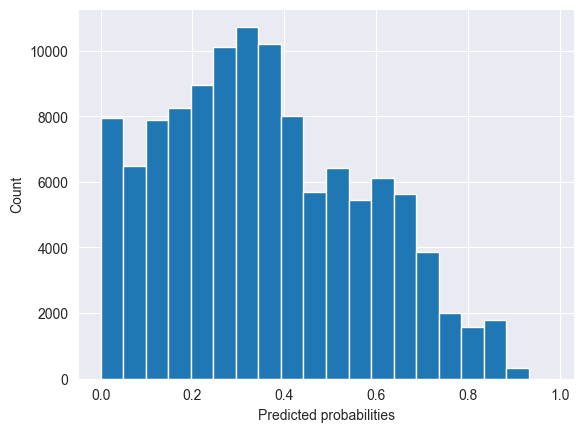

14667/14667 [==============================] - 3s 236us/step

scores for the Training set:
Accuracy: 0.757735
Precision: 0.605428
Recall: 0.698932
F1 Score: 0.61425
AUPRC: 0.469653


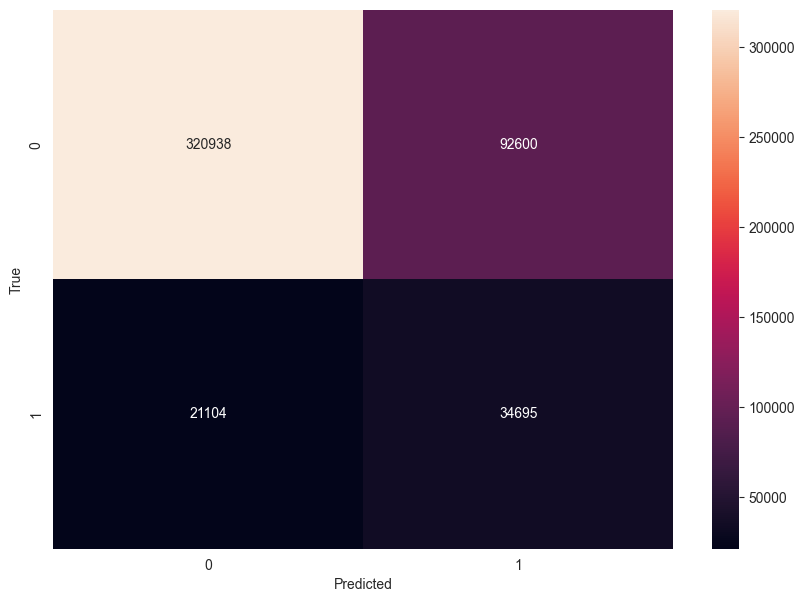

3667/3667 [==============================] - 1s 246us/step

scores for the Testing set:
Accuracy: 0.758359
Precision: 0.60559
Recall: 0.701119
F1 Score: 0.614408
AUPRC: 0.470879


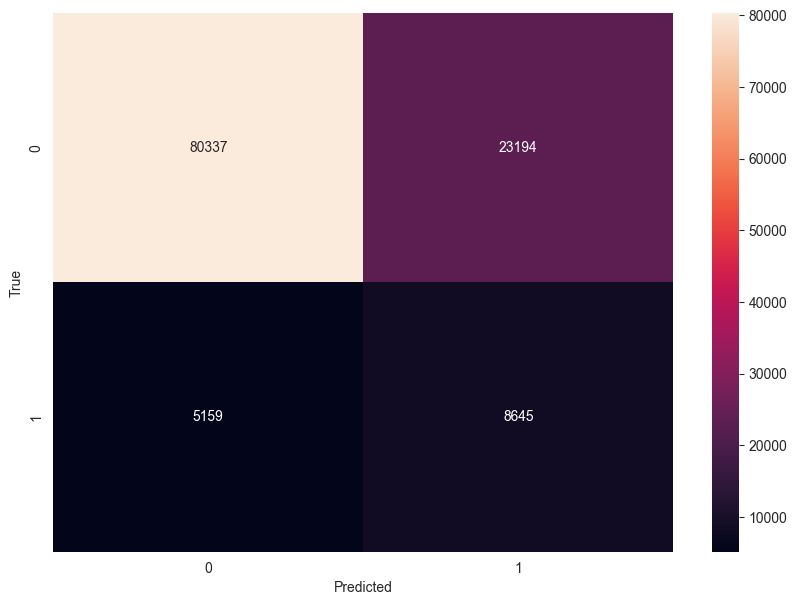

Decision Tree Classifier Training...
Decision Tree Classifier Fitted

scores for the training set:
Accuracy: 0.995246
Precision: 0.995951
Recall: 0.981319
F1 Score: 0.988486
AUPRC: 0.982152


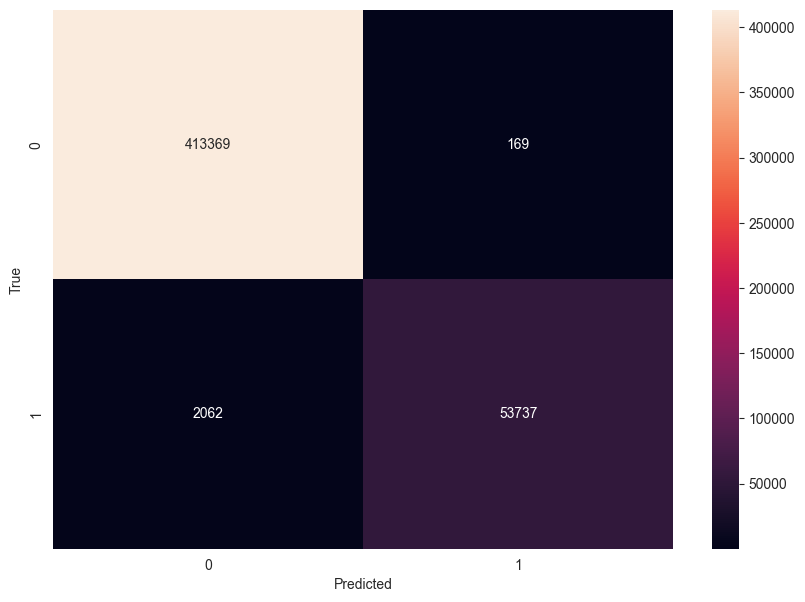


scores for the testing set:
Accuracy: 0.820037
Precision: 0.581428
Recall: 0.588434
F1 Score: 0.584596
AUPRC: 0.314515


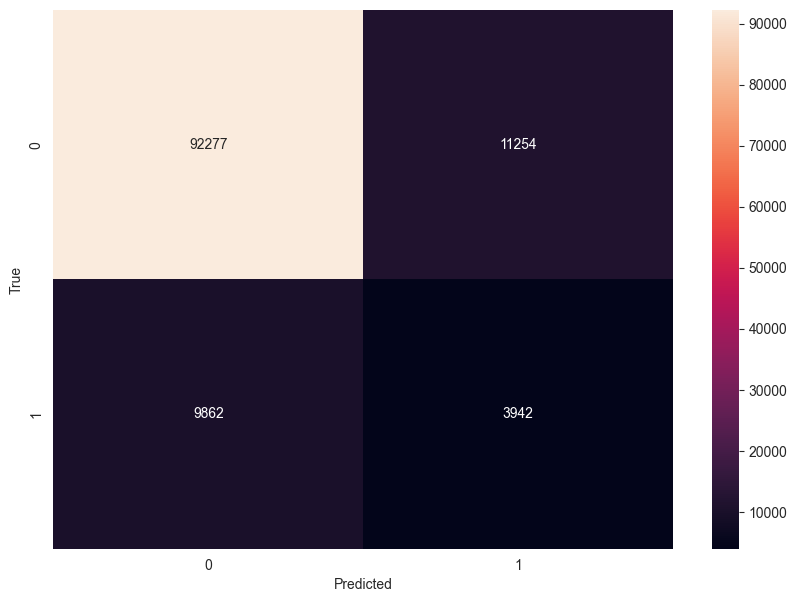

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.995246
Precision: 0.994581
Recall: 0.982652
F1 Score: 0.988517
AUPRC: 0.981935


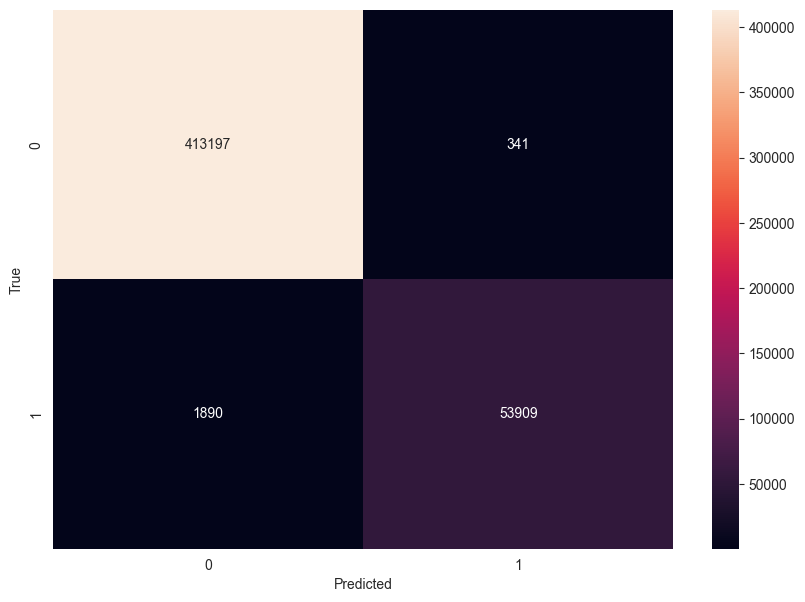


scores for the testing set:
Accuracy: 0.887553
Precision: 0.741881
Recall: 0.567582
F1 Score: 0.588584
AUPRC: 0.418101


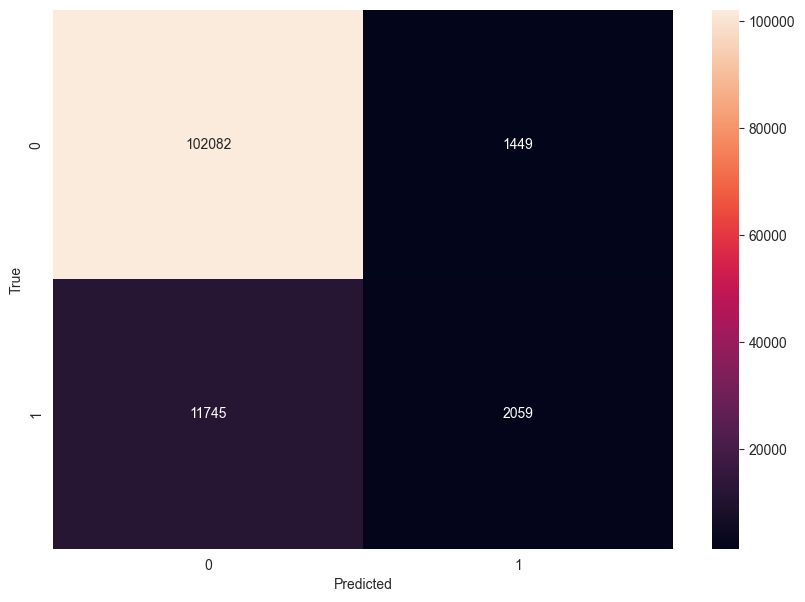

dataset.csv read in successfully as a dataframe


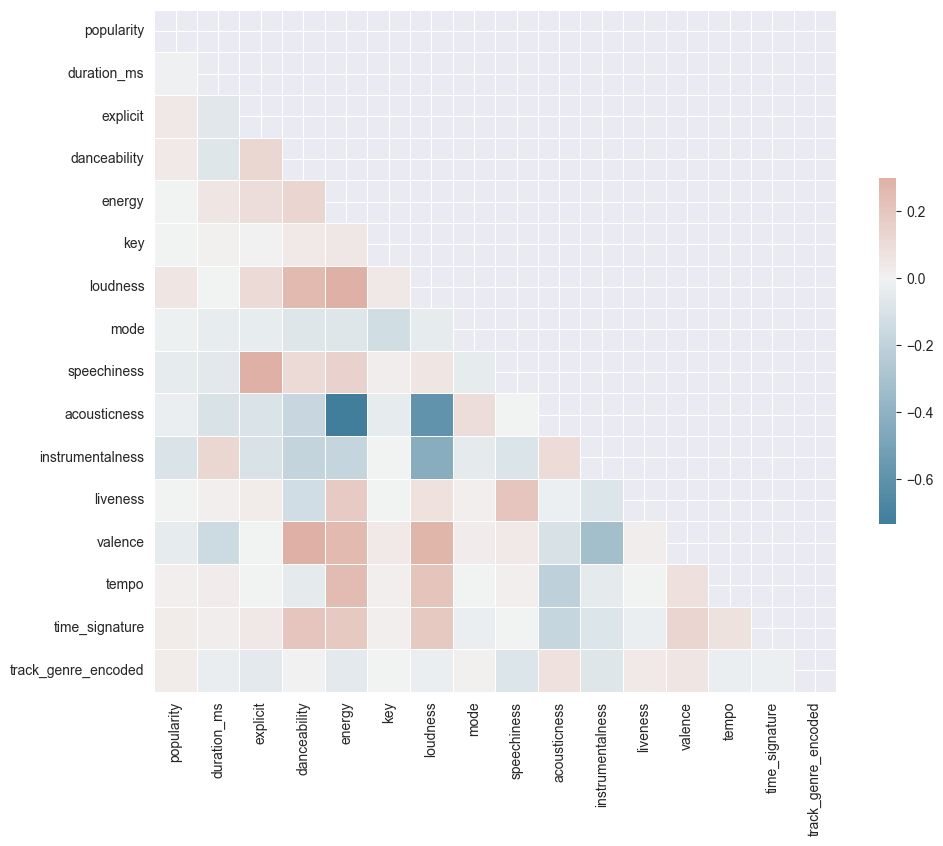

100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


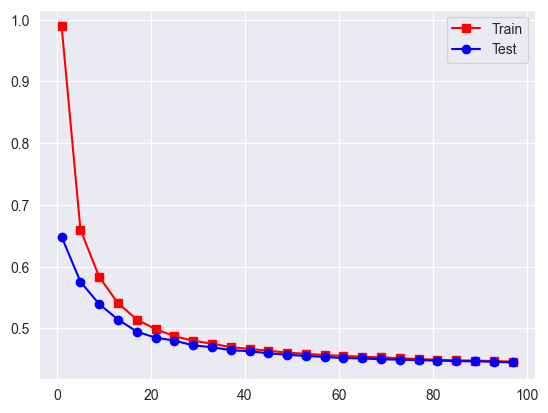

The best k value is : 1 with score: 0.6482744134224833
KNN-Regressor Training...
KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.991721
Precision: 0.988458
Recall: 0.989154
F1 Score: 0.988805
AUPRC: 0.985034


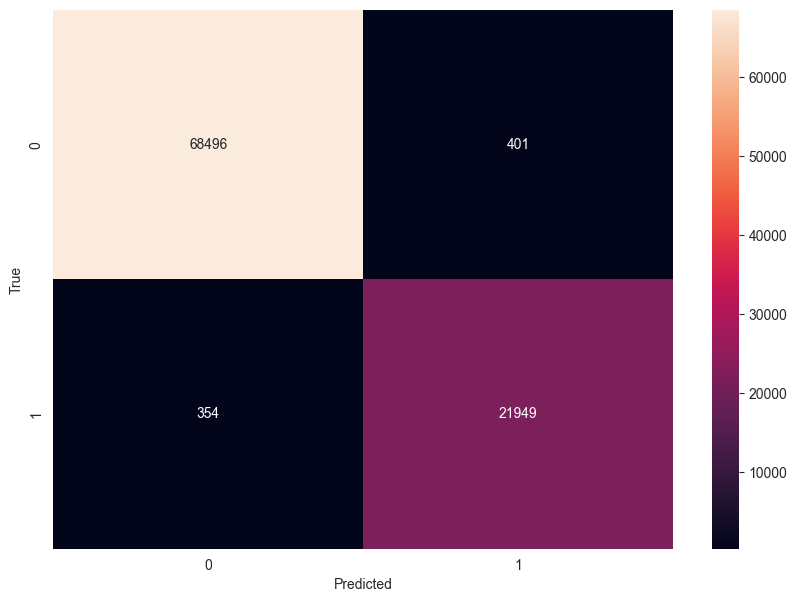


scores for the testing set:
Accuracy: 0.741096
Precision: 0.645434
Recall: 0.646142
F1 Score: 0.645785
AUPRC: 0.526347


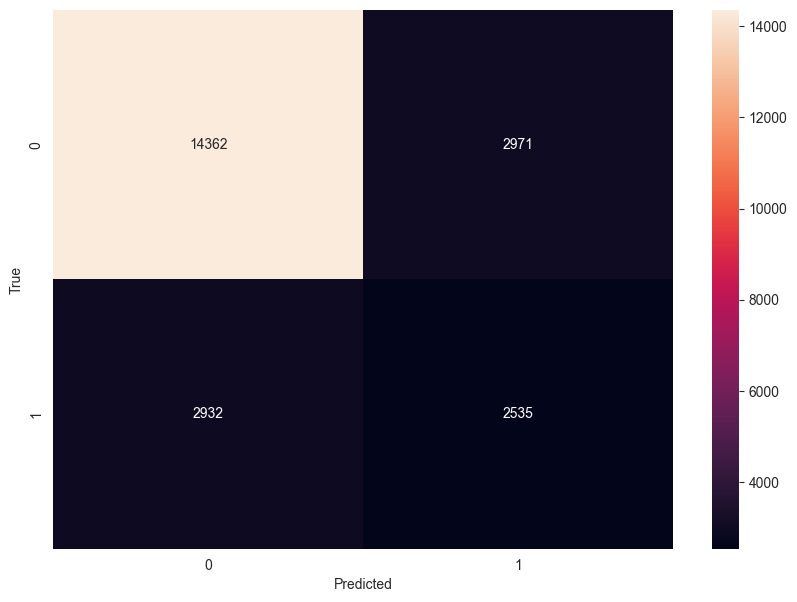

100%|██████████| 25/25 [01:24<00:00,  3.38s/it]


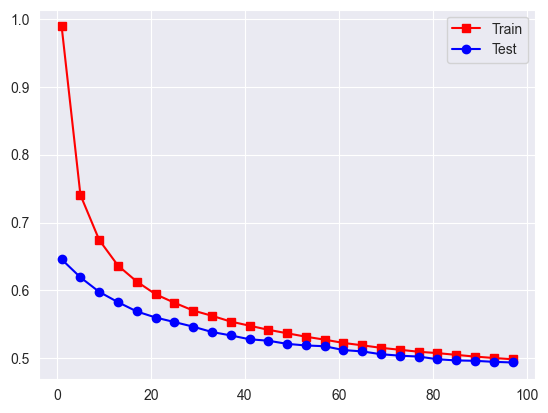

The best k value is : 1 with score: 0.6457846446468074
KNN-Classifier Training...
KNN-Classifier Fitted

scores for the training set:
Accuracy: 0.991721
Precision: 0.988458
Recall: 0.989154
F1 Score: 0.988805
AUPRC: 0.985034


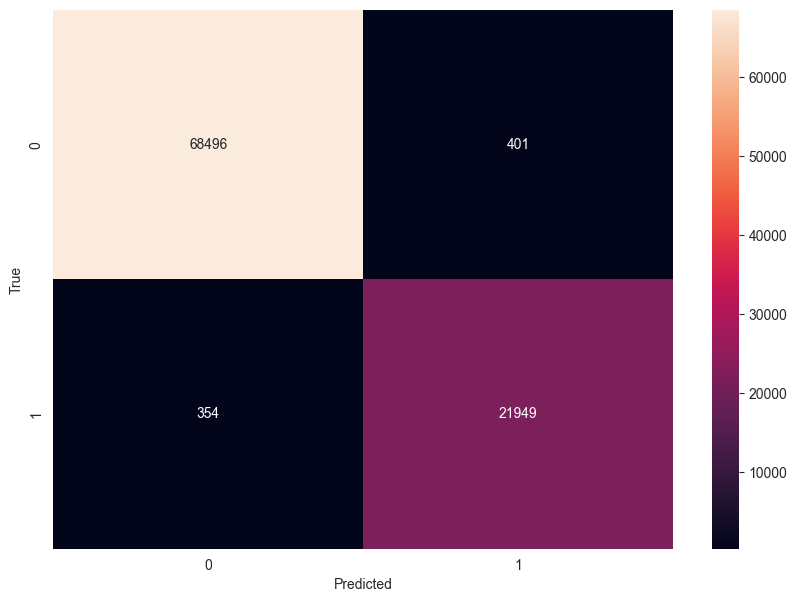


scores for the testing set:
Accuracy: 0.741096
Precision: 0.645434
Recall: 0.646142
F1 Score: 0.645785
AUPRC: 0.526347


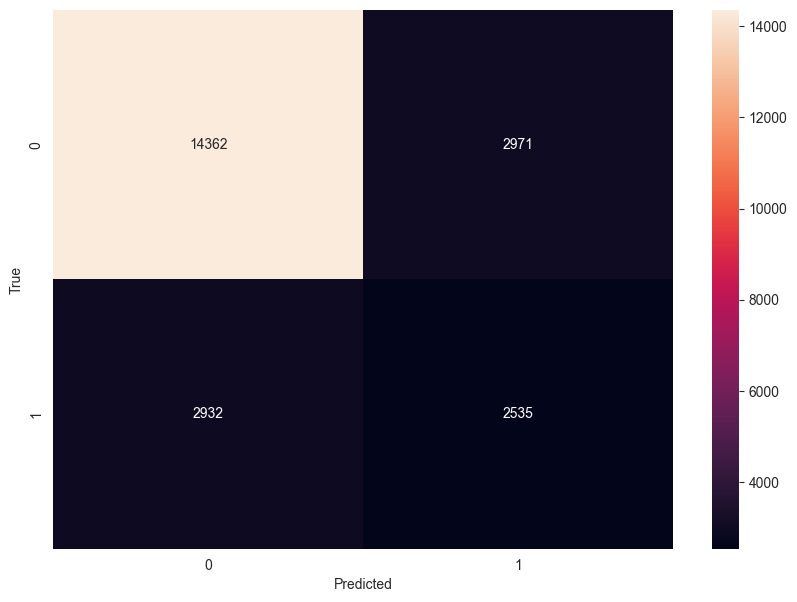

YIIIIIPPPPPEEEEEEEEE
SVM-Classifier Training...
SVM-Classifier Fitted

scores for the training set:
Accuracy: 0.758279
Precision: 0.738224
Recall: 0.508316
F1 Score: 0.449459
AUPRC: 0.488426


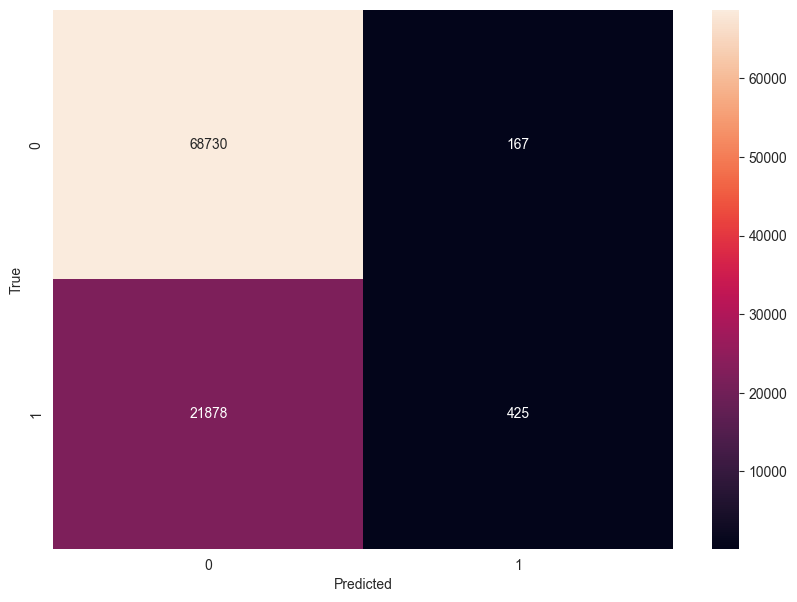


scores for the testing set:
Accuracy: 0.76136
Precision: 0.67829
Recall: 0.505884
F1 Score: 0.446609
AUPRC: 0.422693


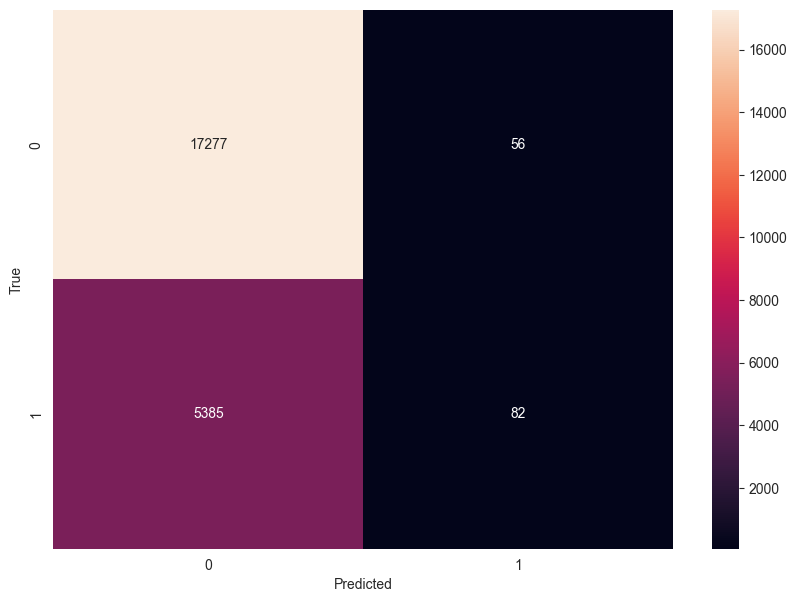

Epoch 1/50
856/912 [===========================>..] - ETA: 0s - loss: 1.4126 - f1_score_nn: 0.2970
Epoch 1: val_f1_score_nn improved from -inf to 0.34966, saving model to best_model.keras
912/912 [==============================] - 1s 788us/step - loss: 1.4099 - f1_score_nn: 0.3017 - val_loss: 0.6565 - val_f1_score_nn: 0.3497
Epoch 2/50
849/912 [==========================>...] - ETA: 0s - loss: 1.3722 - f1_score_nn: 0.3451
Epoch 2: val_f1_score_nn improved from 0.34966 to 0.38775, saving model to best_model.keras
912/912 [==============================] - 1s 728us/step - loss: 1.3715 - f1_score_nn: 0.3476 - val_loss: 0.6582 - val_f1_score_nn: 0.3877
Epoch 3/50
894/912 [============================>.] - ETA: 0s - loss: 1.3550 - f1_score_nn: 0.3776
Epoch 3: val_f1_score_nn improved from 0.38775 to 0.39570, saving model to best_model.keras
912/912 [==============================] - 1s 754us/step - loss: 1.3548 - f1_score_nn: 0.3779 - val_loss: 0.6692 - val_f1_score_nn: 0.3957
Epoch 4/50
83

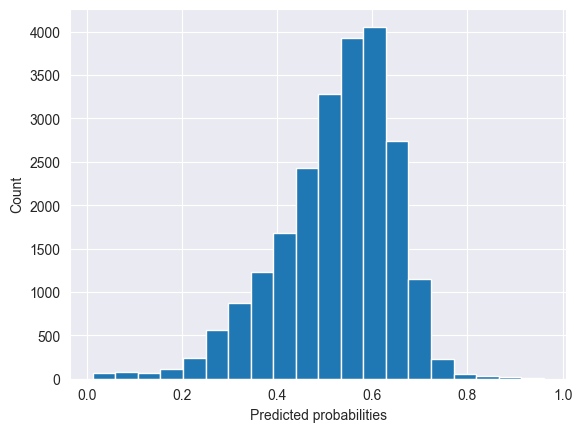

2850/2850 [==============================] - 1s 249us/step

scores for the Training set:
Accuracy: 0.499759
Precision: 0.578497
Recall: 0.597684
F1 Score: 0.493209
AUPRC: 0.57083


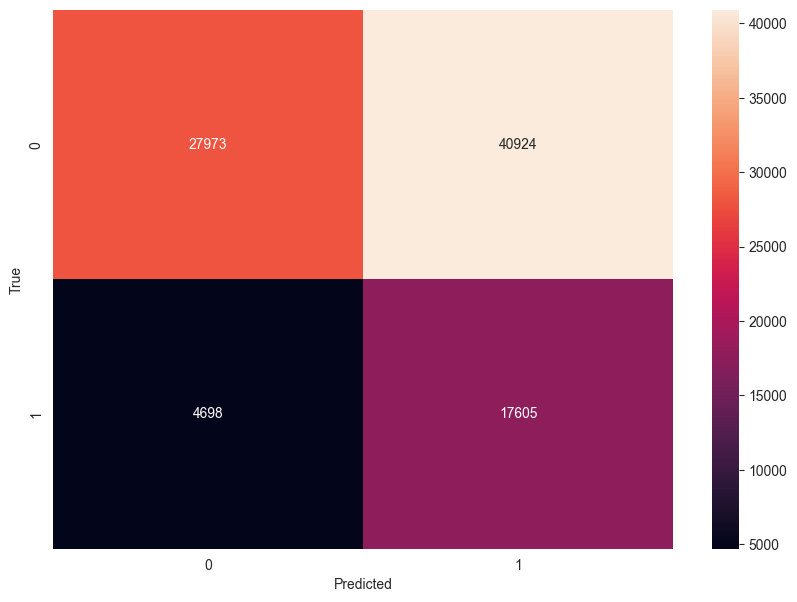

713/713 [==============================] - 0s 262us/step

scores for the Testing set:
Accuracy: 0.492632
Precision: 0.573681
Recall: 0.592671
F1 Score: 0.485684
AUPRC: 0.564356


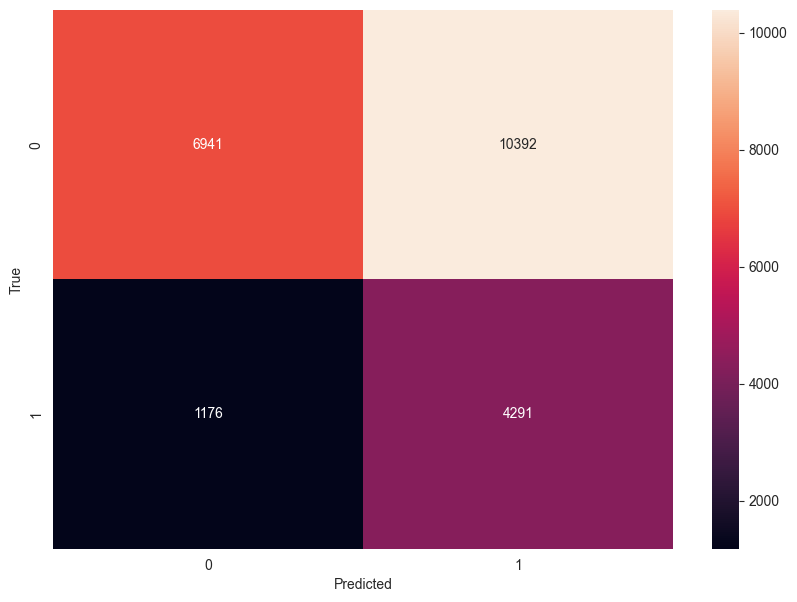

Decision Tree Classifier Training...
Decision Tree Classifier Fitted

scores for the training set:
Accuracy: 0.993289
Precision: 0.995327
Recall: 0.986538
F1 Score: 0.990838
AUPRC: 0.989532


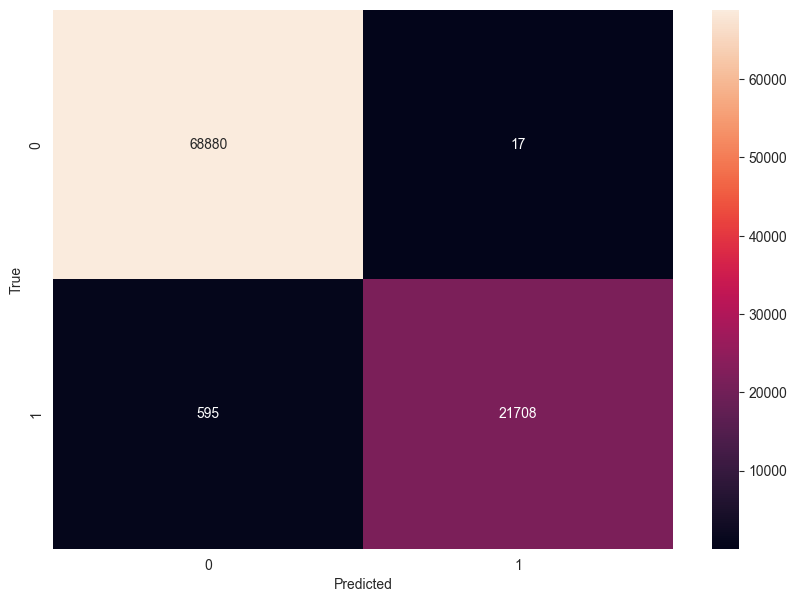


scores for the testing set:
Accuracy: 0.777237
Precision: 0.694424
Recall: 0.694205
F1 Score: 0.694314
AUPRC: 0.590893


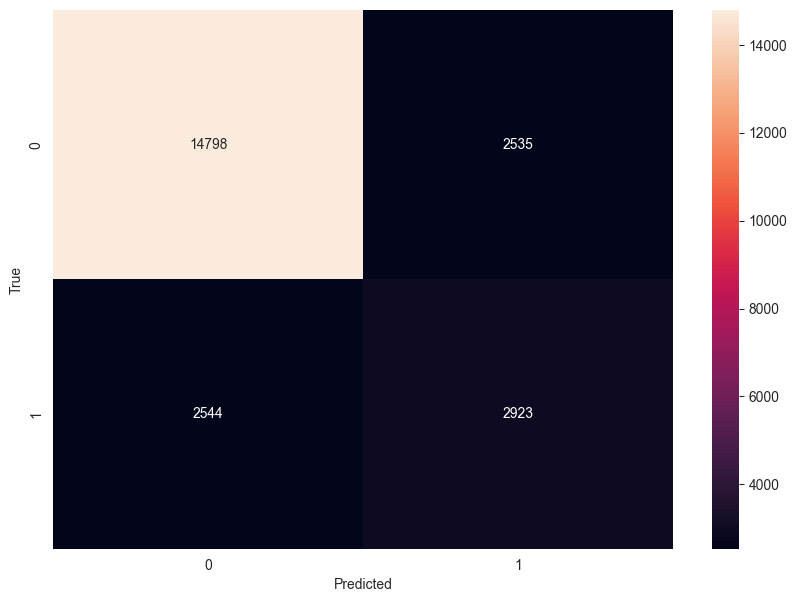

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.993289
Precision: 0.993914
Recall: 0.987902
F1 Score: 0.990864
AUPRC: 0.989005


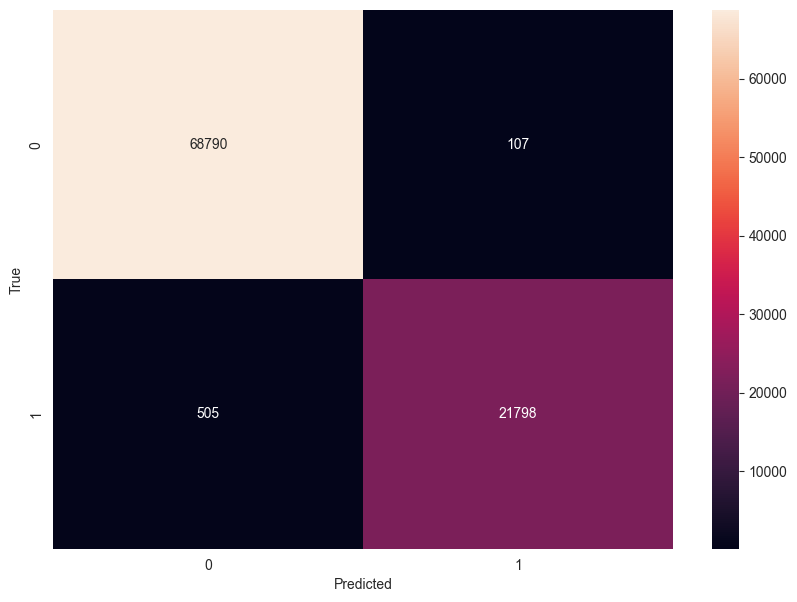


scores for the testing set:
Accuracy: 0.845614
Precision: 0.849511
Recall: 0.70305
F1 Score: 0.738606
AUPRC: 0.710325


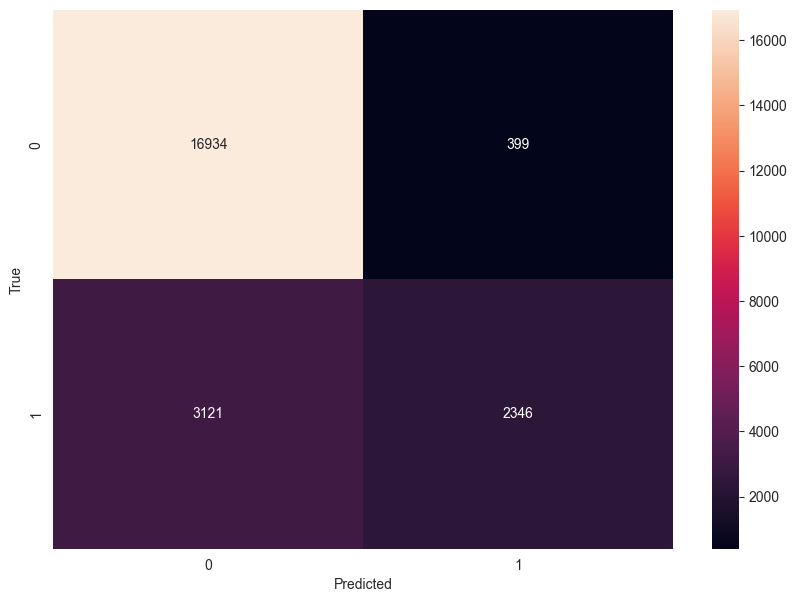


Execution time: 2713.1318929195404 seconds


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_41125/1709792925.py:223: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  results_df.to_csv('resultsof',MINIMUM_POPULARITY_LIMIT,'.csv', index=False)


TypeError: "delimiter" must be string, not int

In [22]:
# Putting file specific info into arrays for easier access
files = ['tracks.csv', 'dataset.csv']
inputs = [
    ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
     'valence', 'tempo', 'time_signature', 'explicit'],

    ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
     'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
]
target = ['popularity']

start_time = time.time()

results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])

for i in range(len(files)):

    df = pd.read_csv('./' + files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning

    # Data cleaning for tracks.csv
    if i == 0:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
        df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])

    # Data cleaning for dataset.csv
    if i == 1:
        df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
        df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])

    print_correlation_matrix(df)

    xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)

    # Training Model 1 KNN-Regressor
    kernelNumber = find_best_kernel_value(False, xtrain, ytrain, xtest, ytest)

    print('KNN-Regressor Training...')
    modelOne = neighbors.KNeighborsRegressor(kernelNumber)
    modelOne.fit(xtrain, ytrain)
    print('KNN-Regressor Fitted')

    # Apply a same threshold to train predictions
    y_train, y_train_pred = predict_and_convert(modelOne, xtrain, ytrain, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i] + ' KNN-Regressor Training')

    y_test, y_test_pred = predict_and_convert(modelOne, xtest, ytest, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i] + ' KNN-Regressor Testing')

    # Training Model 2 KNN-Classifier
    y_train_two = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test_two = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)

    kernelNumber = find_best_kernel_value(True, xtrain, y_train_two, xtest, y_test_two)

    print('KNN-Classifier Training...')
    modelTwo = neighbors.KNeighborsClassifier(kernelNumber)
    modelTwo.fit(xtrain, y_train_two.values.ravel())
    print('KNN-Classifier Fitted')

    y_train_pred = modelTwo.predict(xtrain)
    print('\nscores for the training set:')
    analyze_algorithm(y_train_two, y_train_pred, files[i] + ' KNN-Classifier Training')

    # Apply a same threshold to test predictions
    y_test_pred = modelTwo.predict(xtest)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test_two, y_test_pred, files[i] + ' KNN-Classifier Testing')

    # Training Model 3 SVM-rbf
    # The first dataset is too big to reasonably run with SVM as it generally take O(n^3*d) time for training
    if i == 1:
        # Training Model 3 SVM
        print('YIIIIIPPPPPEEEEEEEEE')
        y_train = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
        y_test = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)

        sc = StandardScaler()
        X_train = sc.fit_transform(xtrain)
        X_test = sc.transform(xtest)

        # Training the SVM model on the Training set using a linear kernel
        print('SVM-Classifier Training...')
        modelThree = SVC(kernel='rbf', random_state=42)
        modelThree.fit(X_train, y_train.values.ravel())
        print('SVM-Classifier Fitted')

        # Predicting the results
        print('\nscores for the training set:')
        y_pred = modelThree.predict(X_train)
        analyze_algorithm(y_train, y_pred, files[i] + ' SVM Training')

        print('\nscores for the testing set:')
        y_pred = modelThree.predict(X_test)
        analyze_algorithm(y_test, y_pred, files[i] + ' SVM Testing')

    # Training Model 4 Convolution Neural Network
    X_train, X_test, y_train, y_test = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    y_train = (y_train > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test = (y_test > MINIMUM_POPULARITY_LIMIT).astype(int)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    # Define the neural network structure
    modelFour = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    modelFour.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[f1_score_nn])

    y_train_numpy = y_train.to_numpy().astype('int64')
    unique_classes, class_counts = np.unique(y_train_numpy, return_counts=True)
    class_weights_dict = {class_label: len(y_train_numpy) / count for class_label, count in
                          zip(unique_classes, class_counts)}

    # Define EarlyStopping and ModelCheckpoint callbacks.
    es = EarlyStopping(monitor='val_f1_score_nn', mode='max', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model.keras', monitor='val_f1_score_nn', mode='max', verbose=1, save_best_only=True,
                         save_format='tf')
    # callbacks=[es, mc]

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # callbacks=[tensorboard_callback, es, mc]
    # Pass class weights and callbacks into model.fit().
    modelFour.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=100,
                  class_weight=class_weights_dict, callbacks=[es, mc])

    # Load the best model
    modelFour = keras.models.load_model('best_model.keras')

    # Make predictions
    predictions = modelFour.predict(X_test)
    plt.hist(predictions, bins=20)
    plt.xlabel('Predicted probabilities')
    plt.ylabel('Count')
    plt.show()

    predictions = (modelFour.predict(X_train) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    print('\nscores for the Training set:')
    analyze_algorithm(y_train, predictions, files[i] + ' Neural Network Training')

    predictions = (modelFour.predict(X_test) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    print('\nscores for the Testing set:')
    analyze_algorithm(y_test, predictions, files[i] + ' Neural Network Testing')

    # Training Model 5 Decision Tree Classifier
    modelFive = DecisionTreeClassifier()
    print('Decision Tree Classifier Training...')
    modelFive.fit(X_train, y_train.values.ravel())
    print('Decision Tree Classifier Fitted')

    y_train_pred = modelFive.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i] + ' Decision Tree Classifier Training')

    y_test_pred = modelFive.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i] + ' Decision Tree Classifier Testing')

    # Training Model 6 Random Forest Classifier
    modelSix = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    print('Random Forest Classifier Training...')
    modelSix.fit(X_train, y_train.values.ravel())
    print('Random Forest Classifier Fitted')

    y_train_pred = modelSix.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i] + ' Random Forest Classifier Training')

    y_test_pred = modelSix.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i] + ' Random Forest Classifier Testing')

# End timing and print the result
end_time = time.time()

print("\nExecution time: {} seconds".format(end_time - start_time))

results_df.to_csv('resultsof'+str(MINIMUM_POPULARITY_LIMIT)+'.csv', index=False)


In [ ]:
# %tensorboard --logdir logs/fit